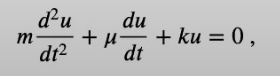

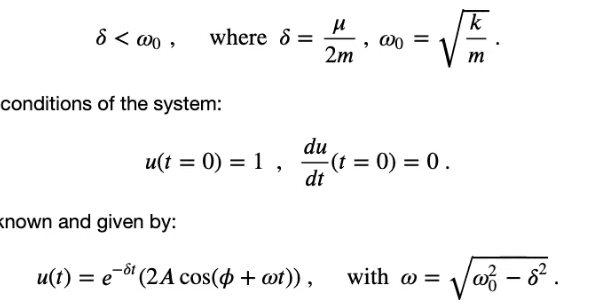

In [14]:
#  Reference: Ben Moseley (Imperial College London)

import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Exact solution
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [16]:
# Network (Method 1 in terms of code structure)
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [17]:
# Network (Method 2 in terms of code structure)
"""
import torch
import torch.nn as nn

class FCN(nn.Module):
    def __init__(self, N_INPUT: int, N_OUTPUT: int, N_HIDDEN: int, N_LAYERS: int):
        super().__init__()
        
        self.activation = nn.Tanh
        
        # Input layer
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),  
            self.activation()            
        )
        # Hidden layers
        self.fch = self._create_hidden_layers(N_HIDDEN, N_LAYERS)
        
        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)  # Output layer

    def _create_hidden_layers(self, N_HIDDEN: int, N_LAYERS: int) -> nn.Sequential:
        #Creates hidden layers for the network.
        layers = []
        for _ in range(N_LAYERS - 1):
            layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) 
            layers.append(self.activation())
            
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #Defines the forward pass of the network
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
"""

'\nimport torch\nimport torch.nn as nn\n\nclass FCN(nn.Module):\n    def __init__(self, N_INPUT: int, N_OUTPUT: int, N_HIDDEN: int, N_LAYERS: int):\n        super().__init__()\n        \n        self.activation = nn.Tanh\n        \n        # Input layer\n        self.fcs = nn.Sequential(\n            nn.Linear(N_INPUT, N_HIDDEN),  \n            self.activation()            \n        )\n        # Hidden layers\n        self.fch = self._create_hidden_layers(N_HIDDEN, N_LAYERS)\n        \n        # Output layer\n        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)  # Output layer\n\n    def _create_hidden_layers(self, N_HIDDEN: int, N_LAYERS: int) -> nn.Sequential:\n        #Creates hidden layers for the network.\n        layers = []\n        for _ in range(N_LAYERS - 1):\n            layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) \n            layers.append(self.activation())\n            \n        return nn.Sequential(*layers)\n\n    def forward(self, x: torch.Tensor) -> torch.Tensor:\n      

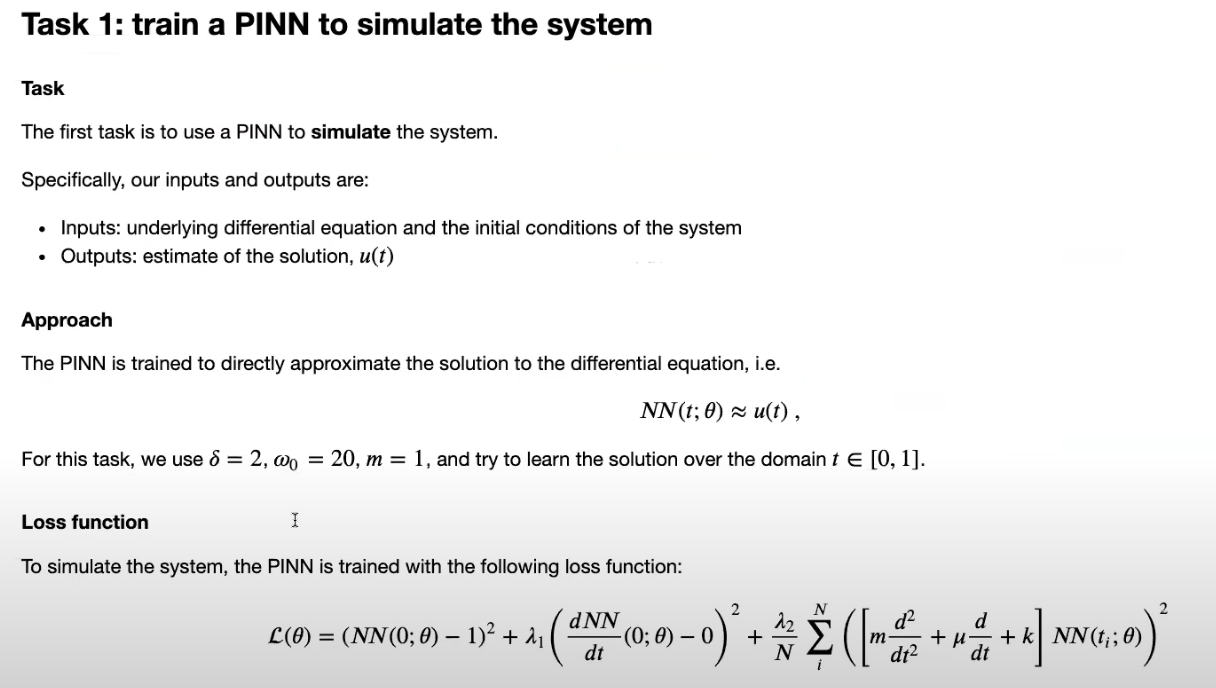

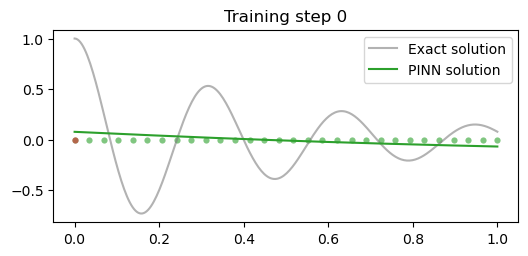

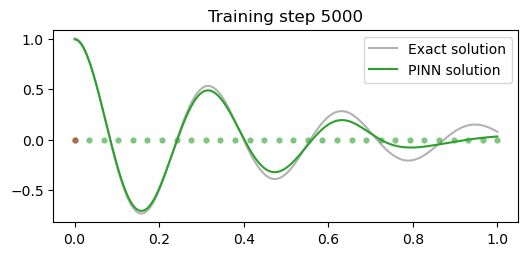

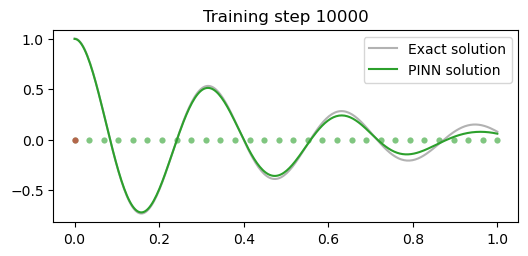

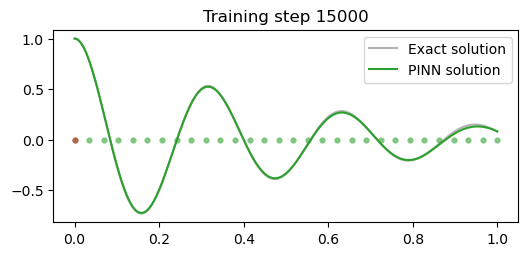

In [18]:
torch.manual_seed(123)

# Instantiate Neural Network
pinn = FCN(1,1,32,3)

# Boundary points and collocation points for physics loss
t_boundary = torch.tensor(0., requires_grad=True).view(-1,1)
t_physics = torch.linspace(0, 1, 30, requires_grad=True).view(-1,1) # collocation points

# Train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1, 300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

for i in range(15001):
    optimizer.zero_grad()

    # compute PINN loss
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    u = pinn(t_boundary)
    loss1 = torch.squeeze((u - 1)**2)
    du = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = torch.squeeze((du - 0)**2)

    # compute physics loss
    u = pinn(t_physics)
    du = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    du2 = torch.autograd.grad(du, t_physics, torch.ones_like(u), create_graph=True)[0]
    loss3 = torch.mean((du2+mu*du+k*u)**2)

    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()


c:\Users\johna\miniconda3\envs\env\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


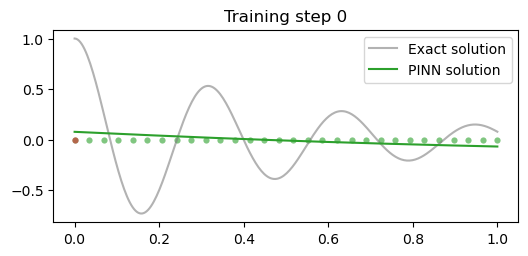

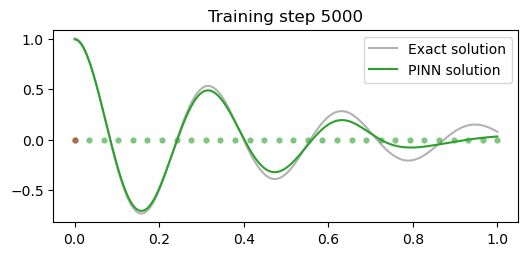

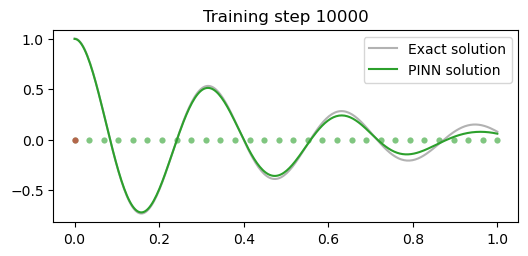

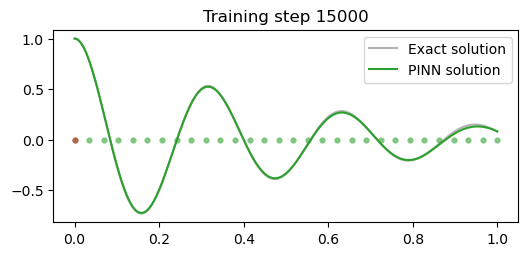

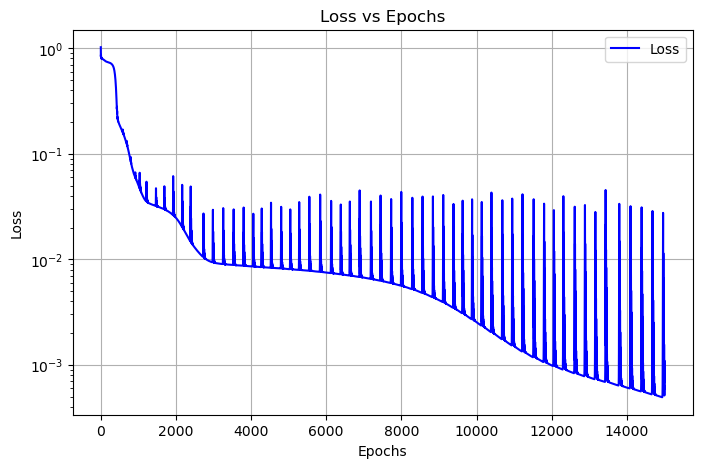

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# Exact solution
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w * t)
    exp = torch.exp(-d * t)
    u = exp * 2 * A * cos
    return u


# Network (Method 1 in terms of code structure)
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


torch.manual_seed(123)

# Instantiate Neural Network
pinn = FCN(1, 1, 32, 3)

# Boundary points and collocation points for physics loss
t_boundary = torch.tensor(0., requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 1, 30, requires_grad=True).view(-1, 1)  # collocation points

# Train the PINN
d, w0 = 2, 20
mu, k = 2 * d, w0**2
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# List to store loss values
losses = []

for i in range(15001):
    optimizer.zero_grad()

    # compute PINN loss
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    u = pinn(t_boundary)
    loss1 = torch.squeeze((u - 1)**2)
    du = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = torch.squeeze((du - 0)**2)

    # compute physics loss
    u = pinn(t_physics)
    du = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    du2 = torch.autograd.grad(du, t_physics, torch.ones_like(u), create_graph=True)[0]
    loss3 = torch.mean((du2 + mu * du + k * u)**2)

    loss = loss1 + lambda1 * loss2 + lambda2 * loss3
    losses.append(loss.item())  # Store the loss value
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_physics.detach()[:, 0], 
                    torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0], 
                    torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

# Plotting loss vs epochs
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss', color='blue')
plt.yscale('log')  # Optional: log scale for better visualization
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()
